Adapted by Carlos Toxtli http://www.carlostoxtli.com/#colab-cifar-3

Credits: https://github.com/Chaitanyaa/ML-CIFAR100

In [ ]:
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 6.6MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [ ]:
# Identifying superclasses indexes

#1 Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# downloaded1 = drive.CreateFile({'id':'1IfioWuWPLvvMvkdVCflMh5v6xVfKwBxW'}) # replace the id with id of file you want to access
# downloaded1.GetContentFile('meta')

!gdown https://drive.google.com/uc?id=1IfioWuWPLvvMvkdVCflMh5v6xVfKwBxW

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
  
meta = unpickle('meta')
k=0
# Looping through the list to find the index of vehicle 1 and vehicle 2
for i in meta[b'coarse_label_names']:
  if i==b'vehicles_1':
    a = k
  if i==b'vehicles_2':
    b = k
  k=k+1  
print('Vehicle 1 index:',a,'\nVehicle 2 index:',b)

Downloading...
From: https://drive.google.com/uc?id=1IfioWuWPLvvMvkdVCflMh5v6xVfKwBxW
To: /content/meta
100% 1.47k/1.47k [00:00<00:00, 3.47MB/s]
Vehicle 1 index: 18 
Vehicle 2 index: 19


## With Cifar-100 dataset in Keras

In [ ]:
# install keras first
!pip install dill
!pip install -q keras

In [ ]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

In [ ]:
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

Using TensorFlow backend.


In [ ]:
#batch_size = 1000
num_classes = 2
'''
epochs_longrun = 500
save_dir = "/work"
res_dir = "/results"
model_name = 'convnet_cifar100'
'''

'\nepochs_longrun = 500\nsave_dir = "/work"\nres_dir = "/results"\nmodel_name = \'convnet_cifar100\'\n'

In [ ]:
from keras.datasets import cifar100

In [ ]:
from __future__ import print_function
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical
from keras.models import load_model

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
from keras.utils import to_categorical
tf.reset_default_graph()
tf.set_random_seed(343)
np.random.seed(343)
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='coarse')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

169009152/169001437 [==============================] - 6s 0us/step
x_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples


In [ ]:
#Combining the training and test data back into one data
x = np.concatenate((x_train,x_test))
y = np.concatenate((y_train,y_test))
print('x shape:', x.shape)
print('y shape:', y.shape)

x shape: (60000, 3, 32, 32)
y shape: (60000, 1)


In [ ]:
# Required subset of data in dataframe
x = x.reshape(x.shape[0],3*32*32)
images_df = pd.DataFrame(x, columns = list(range(0,3072)))
temp = pd.DataFrame(y, columns = ['Target'])
images_df = pd.concat([images_df,temp],axis=1)
vehicle_images = images_df[(images_df['Target']==18) | (images_df['Target']==19) ]
vehicle_images.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3033,3034,3035,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047,3048,3049,3050,3051,3052,3053,3054,3055,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071,Target
6,50,56,52,50,51,61,61,63,66,50,52,52,51,57,59,50,52,52,53,49,55,55,53,53,53,54,51,49,79,97,65,67,55,64,54,52,59,67,89,79,...,86,113,75,59,67,67,66,59,60,69,67,62,70,79,80,76,65,87,162,192,172,183,137,85,76,76,86,85,74,61,58,57,58,64,60,59,64,67,63,18
16,35,27,31,77,136,168,103,101,85,63,63,99,81,95,88,66,78,105,135,108,108,95,99,102,102,105,108,99,99,104,102,111,29,21,25,74,146,168,96,108,...,142,126,92,137,122,134,130,145,154,131,120,123,133,147,149,136,140,134,119,126,125,135,140,122,132,135,122,139,141,143,125,133,148,141,127,151,150,132,118,18
30,88,104,112,81,40,39,41,47,87,119,161,175,175,176,177,178,177,178,180,180,165,86,85,84,87,83,54,45,67,57,66,125,75,79,81,41,24,52,36,18,...,25,26,66,101,112,114,102,95,101,103,110,115,118,119,120,121,124,126,128,131,134,135,134,135,135,134,136,136,133,131,127,128,94,45,28,41,49,53,47,18
36,14,4,6,6,6,6,7,6,12,27,7,5,8,7,7,7,8,8,27,83,72,36,40,43,10,11,8,7,15,24,18,12,14,4,6,6,6,7,7,6,...,42,39,35,33,30,28,27,112,115,118,121,126,126,126,126,123,118,118,116,110,106,104,101,95,89,86,82,77,74,71,70,67,64,62,62,58,54,49,47,19
47,255,253,252,249,243,234,222,210,207,210,212,226,230,200,184,156,133,106,94,93,68,62,61,60,71,79,88,89,80,76,83,86,255,252,252,252,252,248,216,175,...,120,126,123,119,109,101,96,107,109,111,111,106,100,87,74,72,75,88,108,114,112,95,97,99,101,103,97,101,97,84,85,92,107,113,129,132,127,122,114,18


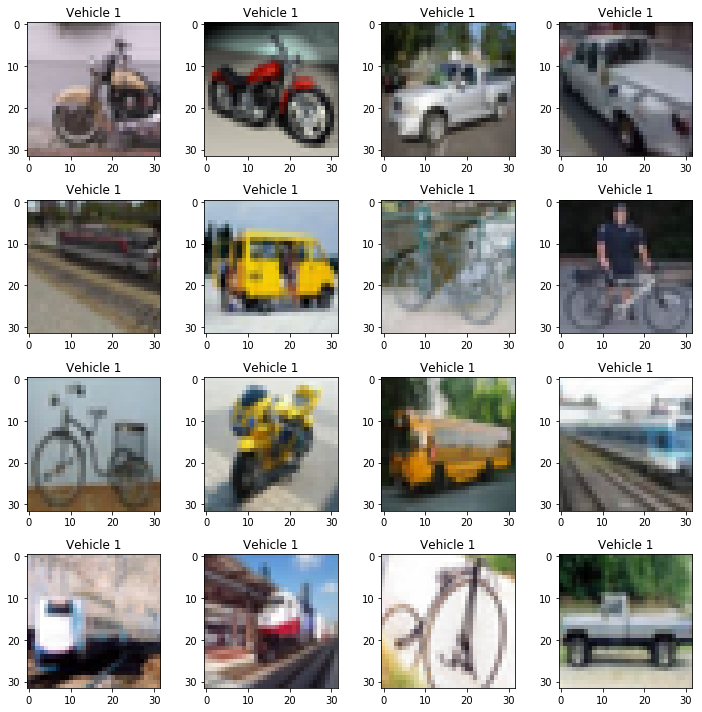

In [ ]:
# To view sample data
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
k=1
for i in x[vehicle_images[vehicle_images['Target']==18].sample(16).index]: # Change Target number here ( 18 = Vehicle 1, 19 = Vehicle 2)
    ax = fig.add_subplot(4, 4, k)
    img = i.reshape(3,32,32).transpose([1, 2, 0])
    fig.set_tight_layout(True) 
    ax=plt.imshow(img)
    ax=plt.title("Vehicle 1")
    k=k+1

In [ ]:
x = vehicle_images.drop(['Target'],axis=1)
y = vehicle_images['Target']

# X_train, y_train split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.20, random_state=42)

In [ ]:
#Normalize data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

# Logistic Regression

In [ ]:
# fitting logistic regression to the training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

KeyboardInterrupt: ignored

In [ ]:
# Score for logistic regression

print(classifier.score(X_test,y_test))

In [ ]:
# Displaying the confusion matrix for logistic regression

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
  for j in range(2):
    plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [ ]:
# Displaying classification report for logistic regression
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
#Images Grid to show actual and predicted labels from logistic regression model

X_test_1 = X_test.as_matrix()
y_test_1 = y_test.as_matrix()
y_pred = np.where(y_pred == 18, "vehicle1", y_pred) 
y_test_1 = np.where(y_test_1 == 18, "vehicle1", y_test_1) 
y_pred = np.where(y_pred == '19', "vehicle2", y_pred) 
y_test_1 = np.where(y_test_1 == '19', "vehicle2", y_test_1)
viz_data = np.random.choice(range(X_test_1.shape[0]),36)
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace = 0.4) #wspace = 0.4)
for idx,img in enumerate(viz_data):
    ax = fig.add_subplot(6, 6,idx+1)
    ax = plt.imshow(X_test_1[img].reshape(3,32,32).transpose([1,2,0]))
    plt.title("Actual: {}\n Predicted: {}".format(y_test_1[img],y_pred[img]))

# KNN Classifier

In [ ]:
# Fitting KNN model

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 100, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [ ]:
# Score for KNN model

print(classifier.score(X_test,y_test))

In [ ]:
# Displaying Confusion Matrix for KNN model

cm = confusion_matrix(y_test, y_pred)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
  for j in range(2):
    plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [ ]:
# Displaying classification report for KNN model

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
#Images Grid to show actual and predicted labels from KNN model

X_test_1 = X_test.as_matrix()
y_test_1 = y_test.as_matrix()
y_pred = np.where(y_pred == 18, "vehicle1", y_pred) 
y_test_1 = np.where(y_test_1 == 18, "vehicle1", y_test_1) 
y_pred = np.where(y_pred == '19', "vehicle2", y_pred) 
y_test_1 = np.where(y_test_1 == '19', "vehicle2", y_test_1)
viz_data = np.random.choice(range(X_test_1.shape[0]),36)
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace = 0.4)
for idx,img in enumerate(viz_data):
    ax = fig.add_subplot(6, 6,idx+1)
    ax = plt.imshow(X_test_1[img].reshape(3,32,32).transpose([1,2,0]))
    plt.title("Actual: {}\n Predicted: {}".format(y_test_1[img],y_pred[img]))

#**Naive Bayes Classifier**

In [ ]:
# fitting Naive Bayes Classifier to the training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [ ]:
# Score for Naive Bayes

print(classifier.score(X_test,y_test))

In [ ]:
# Displaying the confusion matrix for Naive Bayes model

cm = confusion_matrix(y_test, y_pred)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
  for j in range(2):
    plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [ ]:
# Displaying classification report for Naive Bayes model

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
#Images Grid to show actual and predicted labels from Naive Bayes model

X_test_1 = X_test.as_matrix()
y_test_1 = y_test.as_matrix()
y_pred = np.where(y_pred == 18, "vehicle1", y_pred) 
y_test_1 = np.where(y_test_1 == 18, "vehicle1", y_test_1) 
y_pred = np.where(y_pred == '19', "vehicle2", y_pred) 
y_test_1 = np.where(y_test_1 == '19', "vehicle2", y_test_1)
viz_data = np.random.choice(range(X_test_1.shape[0]),36)
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace = 0.4)
for idx,img in enumerate(viz_data):
    ax = fig.add_subplot(6, 6,idx+1)
    ax = plt.imshow(X_test_1[img].reshape(3,32,32).transpose([1,2,0]))
    plt.title("Actual: {} \n Predicted: {}".format(y_test_1[img],y_pred[img]))

# Decision Tree Classifier

In [ ]:
# Fitting Decision Tree Classification to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [ ]:
# Score for decision tree model

print(classifier.score(X_test,y_test))

In [ ]:
# Displaying the confusion matrix for Decision Tree model

cm = confusion_matrix(y_test, y_pred)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
  for j in range(2):
    plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [ ]:
# Displaying classification report for Decision Tree model

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
#Images Grid to show actual and predicted labels from Decision Tree model

X_test_1 = X_test.as_matrix()
y_test_1 = y_test.as_matrix()
y_pred = np.where(y_pred == 18, "vehicle1", y_pred) 
y_test_1 = np.where(y_test_1 == 18, "vehicle1", y_test_1) 
y_pred = np.where(y_pred == '19', "vehicle2", y_pred) 
y_test_1 = np.where(y_test_1 == '19', "vehicle2", y_test_1)
viz_data = np.random.choice(range(X_test_1.shape[0]),36)
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace = 0.4)
for idx,img in enumerate(viz_data):
    ax = fig.add_subplot(6, 6,idx+1)
    ax = plt.imshow(X_test_1[img].reshape(3,32,32).transpose([1,2,0]))
    plt.title("Actual: {} \n Predicted: {}".format(y_test_1[img],y_pred[img]))

# Random Forest Classifer

In [ ]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 155, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [ ]:
# Score for Random forest model
print(classifier.score(X_test,y_test))

In [ ]:
# Displaying the confusion matrix for Random forest model

cm = confusion_matrix(y_test, y_pred)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
  for j in range(2):
    plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [ ]:
# Displaying classification report for random forest model

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
#Images Grid to show actual and predicted labels from random forest model

X_test_1 = X_test.as_matrix()
y_test_1 = y_test.as_matrix()
y_pred = np.where(y_pred == 18, "vehicle1", y_pred) 
y_test_1 = np.where(y_test_1 == 18, "vehicle1", y_test_1) 
y_pred = np.where(y_pred == '19', "vehicle2", y_pred) 
y_test_1 = np.where(y_test_1 == '19', "vehicle2", y_test_1)
viz_data = np.random.choice(range(X_test_1.shape[0]),36)
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace = 0.4)
for idx,img in enumerate(viz_data):
    ax = fig.add_subplot(6, 6,idx+1)
    ax = plt.imshow(X_test_1[img].reshape(3,32,32).transpose([1,2,0]))
    plt.title("Actual: {}\n Predicted: {}".format(y_test_1[img],y_pred[img]))

# SVM

In [ ]:
# fitting SVM model to the training set
from sklearn import svm
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid)
clf.fit(X_train, y_train)
# Predicting the Test set results
y_pred = clf.predict(X_test)

In [ ]:
# Score for SVM model

print(clf.score(X_test,y_test))

In [ ]:
# Displaying the confusion matrix for SVM model

cm = confusion_matrix(y_test, y_pred)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
  for j in range(2):
    plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [ ]:
# Displaying classification report for SVM model

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
#Images Grid to show actual and predicted labels from SVM model
X_test_1 = X_test.as_matrix()
y_test_1 = y_test.as_matrix()
y_pred = np.where(y_pred == 18, "vehicle1", y_pred) 
y_test_1 = np.where(y_test_1 == 18, "vehicle1", y_test_1) 
y_pred = np.where(y_pred == '19', "vehicle2", y_pred) 
y_test_1 = np.where(y_test_1 == '19', "vehicle2", y_test_1)
viz_data = np.random.choice(range(X_test_1.shape[0]),36)
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace = 0.4)
for idx,img in enumerate(viz_data):
    ax = fig.add_subplot(6, 6,idx+1)
    ax = plt.imshow(X_test_1[img].reshape(3,32,32).transpose([1,2,0]))
    plt.title("Actual: {} \n Predicted: {}".format(y_test_1[img],y_pred[img]))

# CNN

In [ ]:
y_train = pd.get_dummies(y_train,drop_first=True)
y_test = pd.get_dummies(y_test,drop_first=True)

In [ ]:
from keras.utils import np_utils
# one hot encode outputs
y_train = to_categorical(y_train,num_classes=2)
y_test = to_categorical(y_test,num_classes=2)
num_classes = y_test.shape[1]

In [ ]:
X_train = X_train.values
X_test = X_test.values

In [ ]:

X_train = X_train.reshape(X_train.shape[0],3,32,32)
X_test = X_test.reshape(X_test.shape[0],3,32,32)

In [ ]:
model3=Sequential()

model3.add(Conv2D(128, (3, 3), padding='same',input_shape=X_train.shape[1:]))
model3.add(Activation('relu'))
model3.add(Conv2D(128, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.20))

model3.add(Conv2D(256, (3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(Conv2D(256, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(512, (3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(Conv2D(512, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.5))

model3.add(Flatten())
model3.add(Dense(1024))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(2))
model3.add(Activation('softmax'))







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 32, 32)       3584      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 32, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 30, 30)       147584    
_________________________________________________________________
activation_2 (Activation)    (None, 128, 30, 30)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 15, 15)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 15, 15)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 15, 15)       295168    
__________

In [ ]:
opt = Adam(lr=0.00005, decay=1e-6)

model3.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
print('Using real-time data augmentation.')

datagen = ImageDataGenerator(
	featurewise_center=False, 
	samplewise_center=False,  
	featurewise_std_normalization=False,
	samplewise_std_normalization=False, 
	zca_whitening=False, 
	rotation_range=0, 
	width_shift_range=0.1, 
	height_shift_range=0.1,
	horizontal_flip=True, 
	vertical_flip=False) 

datagen.fit(X_train)

Using real-time data augmentation.


In [ ]:
#Let's train the model
epochs = 10
#batch_size=128
hist = model3.fit_generator(datagen.flow(X_train, y_train,
    batch_size=128,shuffle=True),
    steps_per_epoch=X_train.shape[0] // 256,
    epochs=epochs,
    validation_data=(X_test, y_test),
    workers=4)

Epoch 1/10
18/18 [==============================] - 9s 506ms/step - loss: 0.6953 - acc: 0.4870 - val_loss: 0.6926 - val_acc: 0.4925
Epoch 2/10
18/18 [==============================] - 3s 146ms/step - loss: 0.6921 - acc: 0.5174 - val_loss: 0.6914 - val_acc: 0.5083
Epoch 3/10
18/18 [==============================] - 3s 189ms/step - loss: 0.6923 - acc: 0.5035 - val_loss: 0.6903 - val_acc: 0.5783
Epoch 4/10
18/18 [==============================] - 3s 146ms/step - loss: 0.6914 - acc: 0.5104 - val_loss: 0.6865 - val_acc: 0.5208
Epoch 5/10
18/18 [==============================] - 3s 144ms/step - loss: 0.6863 - acc: 0.5530 - val_loss: 0.6776 - val_acc: 0.5850
Epoch 6/10
18/18 [==============================] - 3s 146ms/step - loss: 0.6763 - acc: 0.5642 - val_loss: 0.6535 - val_acc: 0.6183
Epoch 7/10
18/18 [==============================] - 3s 143ms/step - loss: 0.6550 - acc: 0.6008 - val_loss: 0.6495 - val_acc: 0.6125
Epoch 8/10
18/18 [==============================] - 3s 147ms/step - loss: 0.

In [ ]:
scores = model3.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'test'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'test'], loc='best')
    plt.show()
    
plot_model_history(hist)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model3.predict(X_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
  for j in range(2):
    plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [ ]:
from sklearn.metrics import classification_report
cp = classification_report(np.argmax(y_test,axis=1),y_pred)
print(cp)

In [ ]:
#print out randomly selected images(black/red labl-->correct/wrong prediction )
def cifar_grid_c(X,Y,inds,n_col, predictions=None):
  if predictions is not None:
    if Y.shape != predictions.shape:
      print("Predictions must equal Y in length!")
      return(None)
  N = len(inds)
  n_row = int(ceil(1.0*N/n_col))
  fig, axes = plt.subplots(n_row,n_col,figsize=(10,10))
  
#  clabels = labels["label_names"]
  clabels = ['vehicles 1','vehicles 2']
  print(type(clabels))
  for j in range(n_row):
    for k in range(n_col):
      i_inds = (j*n_col)+k
      i_data = inds[i_inds]
      
     # axes[j][k].set_axis_off()
      if i_inds < N:
        rgb = X[[i_data,...]]
        #print(rgb.shape)
        img = rgb.reshape(3,32,32).transpose([1, 2, 0])
        axes[j][k].imshow(img, interpolation='nearest')
        label = clabels[np.argmax(Y[i_data,...])]
        axes[j][k].set_title(label)
        if predictions is not None:
          pred = clabels[np.argmax(predictions[i_data,...])]
          if label != pred:
            label += " n"
            axes[j][k].set_title(pred, color='red')            
  
  fig.set_tight_layout(True)

In [ ]:
num_predictions = 36
predict_gen = model3.predict_generator(datagen.flow(X_test, y_test,
    batch_size=256, shuffle=False),
    steps=(X_test.shape[0] // 256)+1, workers=4)

indices = [np.random.choice(range(len(X_test))) 
           for i in range(num_predictions)]

cifar_grid_c(X_test,y_test,indices,6, predictions=predict_gen)